## Initializations

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time

#GLOBAL Variables:
grain = 100
t_1 = 1

#Change these in code as seen fit
t_3 = 0
q = 5

#Conventions:
p = 1
n_phi = p/q #phi in the paper

#Note we take a=1 (lattice constant)

Similarly to the Hofstadter model in a magnetic field with strength B in the Landau gauge as

$$ \textbf{A} = \begin{bmatrix} 0 \\ Bx \\ 0 \end{bmatrix} \phantom{h} \textrm{ such that  } \phantom{h} \nabla \times A = B.$$

We define the Peierls phase as: 

$$ \theta_{ij} = \frac{2\pi}{\phi_0} \int_i^j A \cdot dl = 2\pi n_{\phi}(y_j-y_i)(x_i+\frac{x_j-x_i}{2})$$

Thus, we can now take a look at the Zero Quadratic Model Hamiltonian:

$$
H = -t_1 \sum_{<ij>_1} e^{\mathrm{i}\theta_{ij}} c^\dagger_i c_j 
- t_3 \sum_{<ij>_3} e^{\mathrm{i}\theta_{ij}} c^\dagger_i c_j 
+  \frac{V}{2} \sum_{<ij>_1} \rho_i \rho_j
+ \mathrm{H.c.},
$$


(Here we look at the model without interactions so set $V=0$.
Attempting to determine the band structure, we look at the eigenvalue equation $H\Psi_{mn} = E \Psi_{mn}$ in momentum space.

Thus, we use the ansatz $\Psi_{mn} = e^{ik_xm}e^{ik_yn}\psi_m$ for $0 \leq k_y < 2\pi$ and $0 \leq k_x q <2 \pi$ due to boundary conditions, we also see that $\Psi_{m, n+1} = \Psi_{m, n}$ and $\Psi_{m+q, n} = \Psi_{m, n}$.

Substituting the Peierls phase as well as our wave ansatz acting on our eigenvalue equation, we get (skipping simplifications):


$$ E \psi_m = C^* \psi_{m-2} + B^* \psi_{m-1} + A \psi_m + B\psi_{m+1} + C \psi_{m+2}$$

for $C = -t_3 e^{i2k_x}$, $B = -t_1 e^{ik_x}-t_3 e^{i2\pi n_\phi (m+\frac{1}{2})})e^{ik_x}e^{ik_y}$ and $A = -2(t_1\cos(2\pi n_\phi m +k_y)+t_3\cos(4\pi n_\phi m +2k_y))$

From here, we can write our Hamiltonian in a matrix form and diagonalize this to find the band structure using Python:

In [4]:
def H(q, kx, ky): #Find the 2d-Hamiltonian matrix for some q-value at (k_x, k_y) in momentum space
    n_phi = p/q
    def A(m, ky):
        return -2*(t_1*np.cos(2*np.pi*n_phi*m + ky)+t_3*np.cos(4*np.pi*n_phi*m+2*ky))
    def B(m, kx, ky):
        return -t_1*np.exp(1j*kx)
        #return t_1*np.exp(1j*k_x)+t_3*np.exp(1j*2*np.pi*n_phi*(m+1/2))*np.exp(1j*k_x)*np.exp(1j*k_y)
    def C(kx):
        return -t_3 * np.exp(1j*2*kx)
    
    B_arr_temp = np.diag(np.array([B(i,kx,ky) for i in range(q)]))
    C_arr_temp = np.diag(np.array([C(kx) for i in range(q)]))
    
    A_arr = np.diag(np.array([A(i,ky) for i in range(q)]))
    B_arr = np.roll(B_arr_temp, 1, axis = 1)
    Bc_arr = np.conjugate(np.roll(B_arr_temp, 1, axis = 0))
    C_arr = np.roll(C_arr_temp, 2, axis = 1)
    Cc_arr = np.conjugate(np.roll(C_arr_temp, 2, axis = 0))
    
    return A_arr+B_arr+Bc_arr+C_arr+Cc_arr


def H2(t_3, q, kx, ky): #Find the 2d-Hamiltonian matrix for some q-value at (k_x, k_y) in momentum space
    n_phi = p/q
    def A(m, ky):
        return -2*(t_1*np.cos(2*np.pi*n_phi*m + ky)+t_3*np.cos(4*np.pi*n_phi*m+2*ky))
    def B(m, kx, ky):
        return -t_1*np.exp(1j*kx)
        #return t_1*np.exp(1j*k_x)+t_3*np.exp(1j*2*np.pi*n_phi*(m+1/2))*np.exp(1j*k_x)*np.exp(1j*k_y)
    def C(kx):
        return -t_3 * np.exp(1j*2*kx)
    
    B_arr_temp = np.diag(np.array([B(i,kx,ky) for i in range(q)]))
    C_arr_temp = np.diag(np.array([C(kx) for i in range(q)]))
    
    A_arr = np.diag(np.array([A(i,ky) for i in range(q)]))
    B_arr = np.roll(B_arr_temp, 1, axis = 1)
    Bc_arr = np.conjugate(np.roll(B_arr_temp, 1, axis = 0))
    C_arr = np.roll(C_arr_temp, 2, axis = 1)
    Cc_arr = np.conjugate(np.roll(C_arr_temp, 2, axis = 0))
    
    return A_arr+B_arr+Bc_arr+C_arr+Cc_arr


def H_eigenvectors(q):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    eigenvectors_arr = np.empty((q, len(k_x), len(k_y), q),dtype = "complex_")
    for i, kx in enumerate(k_x):
        for j, ky in enumerate(k_y):
            matrix = H(q, kx, ky)
            assert(np.all(0 == (matrix - np.conj(matrix.T))))
            eigenvalues, eigenvectors = np.linalg.eigh(matrix)
            for a in range(q):
                eigenvectors_arr[a, i, j, :] = eigenvectors[:, a]
    return eigenvectors_arr

def H_eigenvectors2(t_3, q, k_x, k_y):
    eigenvectors_arr = np.empty((q, len(k_x), len(k_y), q),dtype = "complex_")
    for i, kx in enumerate(k_x):
        for j, ky in enumerate(k_y):
            matrix = H2(t_3, q, kx, ky)
            assert(np.all(0 == (matrix - np.conj(matrix.T))))
            eigenvalues, eigenvectors = np.linalg.eigh(matrix)
            for a in range(q):
                eigenvectors_arr[a, i, j, :] = eigenvectors[:, a]
    return eigenvectors_arr

def H_eigenvalues(q):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    eigenvalues_arr = np.empty((q, len(k_x), len(k_y)))
    for i, kx in enumerate(k_x):
        for j, ky in enumerate(k_y):
            matrix = H(q, kx, ky)
            assert(np.all(0 == (matrix - np.conj(matrix.T))))
            eigenvalues, eigenvectors = np.linalg.eigh(matrix)
            for a in range(q):
                eigenvalues_arr[a, i, j] = eigenvalues[a]
    return eigenvalues_arr

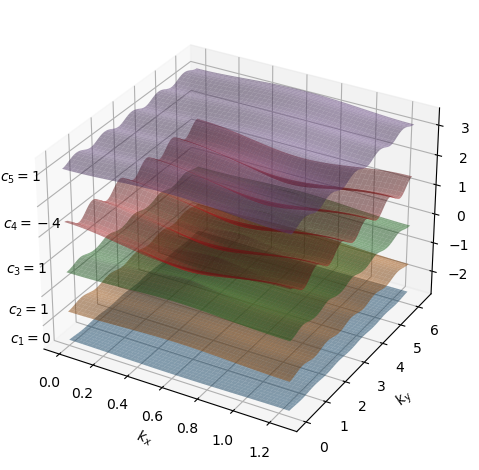

[-2.6067945057585495, -1.6276412907378834, -0.28647450843757877, 1.3932690141961297, 3.127641290737886]


In [5]:
q=5
t_3 = -0.25
eigenvalues_arr = H_eigenvalues(q)
eigenvectors_arr = H_eigenvectors(q)

k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
K_x, K_y = np.meshgrid(k_x, k_y, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for a in range(q):
    ax.plot_surface(K_x, K_y, eigenvalues_arr[a], alpha=0.5)

ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel('Energy (t)')

ax.text(0, -2.5, eigenvalues_arr[0][0][0]+1.5, r'$c_1={}$'.format(0))
ax.text(0, -2.5, eigenvalues_arr[1][0][0]+1.5, r'$c_2={}$'.format(1))
ax.text(0, -2.5, eigenvalues_arr[2][0][0]+1.5, r'$c_3={}$'.format(1))
ax.text(0, -2.5, eigenvalues_arr[3][0][0]+1.25, r'$c_4={}$'.format(-4))
ax.text(0, -2.5, eigenvalues_arr[4][0][0]+1, r'$c_5={}$'.format(1))
plt.tight_layout()
plt.savefig('band_structure_t3=-025_q=5.png', dpi = 1000)
plt.show()
print([eigenvalues_arr[i][0][0] for i in range(q)])

## Chern number


Computing chern numbers, we have $$c_\mu = \frac{1}{i 2\pi}\int_{\textrm{FBZ}} \langle \frac{\partial\psi_\mu(k)}{\partial x}|\frac{\partial\psi_\mu(k)}{\partial y} \rangle - \langle \frac{\partial\psi_\mu(k)}{\partial y}|\frac{\partial\psi_\mu(k)}{\partial x} \rangle d^2 k$$

For some reason this was not working numerically. From (https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-4-4638&id=426551), using a different computation scheme as such, we get our answer:




$$c_n  = \frac{1}{2 \pi} \int_{\textrm{BZ}} \mathbf{F}_{n}(\mathbf{k}) \textrm{d} \mathbf{k}\\ $$


$$c_\mu = \frac{1}{i 2\pi}\int_{\textrm{FBZ}} \partial_x \langle \psi_\mu(k)|\partial_y \psi_\mu(k) \rangle - \partial_y \langle\psi_\mu(k)|\partial_x\psi_\mu(k) \rangle d^2 k$$


substituting for derivatives using a first order finite difference and simplifying by approximating through link variables at small values and Taylor expanding, we get:


$$ {c_n= \frac{1}{2 \pi} \sum_{\mathbf{k}\in\textrm{BZ}} \operatorname{Im} \ln\left[{ U_{\mathbf{k}_1 \rightarrow \mathbf{k}_2}^{(n)} U_{\mathbf{k}_2 \rightarrow \mathbf{k}_3 }^{(n)} U_{\mathbf{k}_3\rightarrow \mathbf{k}_4}^{(n)} U_{\mathbf{k}_4 \rightarrow \mathbf{k}_1}^{(n)} }\right]}
$$



with $U_{\mathbf {k}_{\alpha } \rightarrow \mathbf {k}_{\beta }}^{(n)} \equiv \frac {\left \langle \mathbf {u}_{n,e,\mathbf {k}_{\alpha }} | \mathbf {u}_{n,e, \mathbf {k}_{\beta }}\right \rangle }{\left |\left \langle \mathbf {u}_{n,e,\mathbf {k}_{\alpha }} | \mathbf {u}_{n,e, \mathbf {k}_{\beta }}\right \rangle \right |}$.




In [6]:
def chern_number(q, i):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    chern_sum = 0
    eigenvectors_temp = H_eigenvectors(q)
    for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            chern_sum += chern_number_helper(eigenvectors_temp, i, xi, yi)
    return (1/ (2 * np.pi)) * chern_sum

def chern_number_helper(eigenvectors_temp, i, x, y):
    psi_1 = eigenvectors_temp[i, x % len(k_x), y % len(k_y), :]
    psi_2 = eigenvectors_temp[i, (x + 1) % len(k_x), y % len(k_y), :]
    psi_3 = eigenvectors_temp[i, (x+1) % len(k_x), (y + 1) % len(k_y), :]
    psi_4 = eigenvectors_temp[i, x % len(k_x), (y + 1) % len(k_y), :]

    U12 = np.vdot(psi_1, psi_2)/np.abs(np.vdot(psi_1, psi_2))
    U23 = np.vdot(psi_2, psi_3)/np.abs(np.vdot(psi_2, psi_3))
    U34 = np.vdot(psi_3, psi_4)/np.abs(np.vdot(psi_3, psi_4))
    U41 = np.vdot(psi_4, psi_1)/np.abs(np.vdot(psi_4, psi_1))

    return -1*np.imag(np.log(U12*U23*U34*U41))
t_3 = -0.25
q=5
print([chern_number(q, i) for i in range(q)])

[1.0000000000000007, 1.000000000000004, 1.000000000000004, -3.9999999999999796, 1.0000000000000018]


## Quantum Geometric Tensor Calculations

Note using finite differences we can write

$$
\mathcal{R}_{ab} = \langle \partial_{k_a} u^s (k) | \partial_{k_b}  u^s (k) \rangle - \langle \partial_{k_a} u^s (k) | u^s (k) \rangle \langle u^s (k) | \partial_{k_b} u^s (k) \rangle
$$

into: 

$$
\mathcal{R}_{ab} = \frac{1}{\Delta a \Delta b}(\langle u^s (k+\Delta k_a) | u^s (k+\Delta k_b) \rangle - \langle u^s (k+\Delta k_a) | u^s (k) \rangle \langle u^s (k) | u^s (k+\Delta k_b) \rangle
$$




In [14]:
def qgt(H_eigenvectors_arr, i, ikx, iky): #Outputs quantum geometric tensor in 2d matrix form (xy component indexed as [0,1])
    dx, dy = (k_x[1]-k_x[0])/100000, (k_y[1]-k_y[0])/100000
    eig_0 = H_eigenvectors_arr[0][i, ikx % len(k_x), iky % len(k_y), :]
    eig_x = H_eigenvectors_arr[1][i, ikx % len(k_x), iky % len(k_y), :]
    eig_y = H_eigenvectors_arr[2][i, ikx % len(k_x), iky % len(k_y), :]
    eigs = {}
    eigs.update({"x": eig_x})
    eigs.update({"y": eig_y})
    grad = {}
    grad.update({"x": (eig_x-eig_0)/dx})
    grad.update({"y": (eig_y-eig_0)/dy})
    return np.array([[np.vdot(grad[u], grad[v]) - np.vdot(grad[u], eig_0)*np.vdot(eig_0, grad[v]) for u in ["x", "y"]] for v in ["x", "y"]])
    
def fs_metric(H_eigenvectors_arr, i, ikx, iky): #Outputs the Fubini-Study metric in 2d matrix form (just the real part)
    return np.real(qgt(H_eigenvectors_arr, i, ikx, iky))

def berry_curv(H_eigenvectors_arr, i, ikx, iky): #Outputs Berry Curvature in 2d matrix form
    return -2*np.imag(qgt(H_eigenvectors_arr, i, ikx , iky))

In [8]:
def chern_number_qgt(q, i): #Chern number calculation using the quantum geometric tensor
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    H_eigenvectors_arr_0 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain))
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi, grain)
    H_eigenvectors_arr_1 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi/q, grain))
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)+tdy
    H_eigenvectors_arr_2 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain)+tdy)
    H_eigenvectors_arr = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    chern_sum = 0
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            chern_sum += berry_curv(H_eigenvectors_arr, i, xi, yi)[1,0]*dx*dy
    return (1/ (2 * np.pi)) * chern_sum

In [9]:
def berry_curv_std(q, i): #Chern number calculation using the quantum geometric tensor
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    H_eigenvectors_arr_0 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain))
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi, grain)
    H_eigenvectors_arr_1 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi/q, grain))
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)+tdy
    H_eigenvectors_arr_2 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain)+tdy)
    H_eigenvectors_arr = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    berry_curvs = np.zeros((len(k_x)-1, len(k_y)-1))
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            berry_curvs[xi][yi]  = berry_curv(H_eigenvectors_arr, i, xi, yi)[1,0]*dx*dy
    return np.std(berry_curvs)

In [10]:
def berry_curv_fluct(q, i): #Chern number calculation using the quantum geometric tensor
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    H_eigenvectors_arr_0 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain))
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi, grain)
    H_eigenvectors_arr_1 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi/q, grain))
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)+tdy
    H_eigenvectors_arr_2 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain)+tdy)
    H_eigenvectors_arr = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    berry_curvs = np.zeros((len(k_x)-1, len(k_y)-1))
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            berry_curvs[xi][yi]  = berry_curv(H_eigenvectors_arr, i, xi, yi)[1,0]*dx*dy
    return np.std(berry_curvs)

In [11]:
#Test for chern_number_qgt
q=5
print([chern_number_qgt(q, i) for i in range(q)])

[99.85840735224357, 99.72765467373165, 101.30188026222773, -399.65770686468875, 99.88658043632368]


### < TISM > and < DISM > functions

In [12]:
def TISM(H_eigenvectors_arr, i, xi, yi): #Finds TISM at some xi and yi indices in k_x and k_y respectively
    return np.trace(fs_metric(H_eigenvectors_arr, i, xi, yi)) - np.abs(berry_curv(H_eigenvectors_arr, i ,xi ,yi)[0,1])

def DISM(H_eigenvectors_arr, i, xi, yi): #Finds TISM at some xi and yi indices in k_x and k_y respectively
    return np.linalg.det(fs_metric(H_eigenvectors_arr, i, xi, yi)) - 1/4*np.abs(berry_curv(H_eigenvectors_arr, i, xi, yi)[0,1])**2

def TISM_int(t_3, q, i): #INTEGRATES TISM over the Magnetic Brouillon Zone
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    H_eigenvectors_arr_0 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain))
    H_eigenvectors_arr_1 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi, grain))
    H_eigenvectors_arr_2 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)+tdy)
    H_temp = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    n_phi = p/q
    tisms = np.empty((len(k_x)-1, len(k_y)-1))
    for xi in range(len(k_x)-1):
            for yi in range(len(k_y)-1):
                tisms[xi][yi] = (np.trace(fs_metric(H_temp, 0, xi, yi)) - np.abs(berry_curv(H_temp, 0 ,xi ,yi)[0,1]))
    return np.sum(tisms)*dx*dy/(2*np.pi)

def bc_std(t_3, q, i): 
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    H_eigenvectors_arr_0 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain))
    H_eigenvectors_arr_1 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi, grain))
    H_eigenvectors_arr_2 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)+tdy)
    H_temp = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    n_phi = p/q
    bc = np.empty((len(k_x)-1, len(k_y)-1))
    for xi in range(len(k_x)-1):
            for yi in range(len(k_y)-1):
                bc[xi][yi] = berry_curv(H_temp, 0 ,xi ,yi)[0,1]
    return np.std(bc)

def g_std(t_3, q, i): 
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    H_eigenvectors_arr_0 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain))
    H_eigenvectors_arr_1 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi, grain))
    H_eigenvectors_arr_2 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)+tdy)
    H_temp = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    n_phi = p/q
    g1 = np.empty((len(k_x)-1, len(k_y)-1))
    g2 = np.empty((len(k_x)-1, len(k_y)-1))
    g3 = np.empty((len(k_x)-1, len(k_y)-1))
    g4 = np.empty((len(k_x)-1, len(k_y)-1))
    for xi in range(len(k_x)-1):
            for yi in range(len(k_y)-1):
                qgt_arr = qgt(H_temp, 0 ,xi ,yi)
                g1[xi][yi] = qgt_arr[0,0]
                g2[xi][yi] = qgt_arr[0,1]
                g3[xi][yi] = qgt_arr[1,0]
                g4[xi][yi] = qgt_arr[1,1]
    return 1/2*(np.std(g1)+np.std(g2)+np.std(g3)+np.std(g4))


def DISM_int(t_3, q, i): #Integrates the DISM over the Magnetic Brouillon Zone
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    H_eigenvectors_arr_0 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain))
    H_eigenvectors_arr_1 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi, grain))
    H_eigenvectors_arr_2 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)+tdy)
    H_temp = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    n_phi = p/q
    disms = np.empty((len(k_x)-1, len(k_y)-1))
    for xi in range(len(k_x)-1):
            for yi in range(len(k_y)-1):
                disms[xi][yi] = np.linalg.det(fs_metric(H_temp, i, xi, yi)) - 1/4*np.abs(berry_curv(H_temp, i, xi, yi)[0,1])**2
    return np.sum(disms)*dx*dy/(2*np.pi)



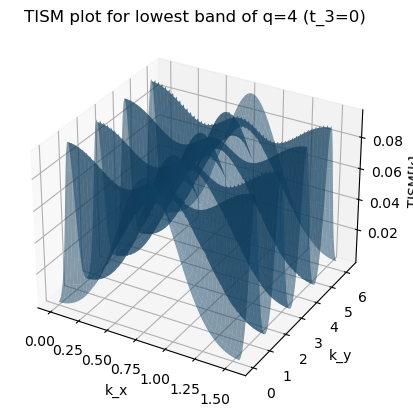

--- 4.005380153656006 seconds ---
Integrated TISM Value for (q=4, t_3=0):0.08307669767450017


In [12]:
#Gives a 3d mapping of TISM values give some kx and ky values over the MBZ
start_time = time.time()
q = 4
t_3 = 0
k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
n_phi = p/q
H_eigenvectors_arr_0 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain))
H_eigenvectors_arr_1 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi, grain))
H_eigenvectors_arr_2 = H_eigenvectors2(t_3, q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)+tdy)
H_eigenvectors_arr = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
tisms = np.empty((len(k_x)-1, len(k_y)-1))
for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            tisms[xi][yi] = (np.trace(fs_metric(H_eigenvectors_arr, 0, xi, yi)) 
                             - np.abs(berry_curv(H_eigenvectors_arr, 0 ,xi ,yi)[0,1]))
K_x, K_y = np.meshgrid(k_x[:-1], k_y[:-1], indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_x, K_y, tisms, alpha=0.5)

ax.set_title('TISM plot for lowest band of q={} (t_3=0)'.format(q))
ax.set_xlabel('k_x')
ax.set_ylabel('k_y')
ax.set_zlabel('TISM[k]')
plt.savefig('band_structure')
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))
print('Integrated TISM Value for (q={}, t_3={}):{}'.format(q, t_3, np.sum(tisms)*dx*dy/(2*np.pi)))

## Fig. 3 comparison  < TISM>

running


/Users/mathiraja/miniconda3/envs/tenpy/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


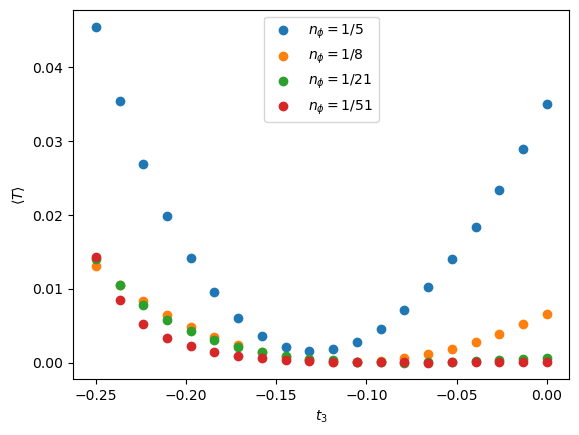

--- 101.92709231376648 seconds ---


In [22]:
start_time = time.time()
from joblib import Parallel, delayed
print('running')
grain = 100
qs = np.array([5, 8, 21, 51])
def my_task(q, t_temp):
    n_phi = 1/q
    points = np.array([None, None])
    t_3 = t_temp
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    tism = np.array([t_3, TISM_int(t_3, q, 0)])
    return tism
for q in qs:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    results = np.array(Parallel(n_jobs=8)(delayed(my_task)(q, t_temp) for t_temp in np.linspace(-0.25, 0, 20)))
    plt.scatter(results[:, 0], results[:, 1], label = r'$n_\phi = 1/{}$'.format(q))
plt.legend()
plt.xlabel(r'$t_3$')
plt.ylabel(r'$\langle T \rangle$')
plt.savefig('TISMplot.png', dpi = 1000)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))



#https://joblib.readthedocs.io/en/stable/

running


/Users/mathiraja/miniconda3/envs/tenpy/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


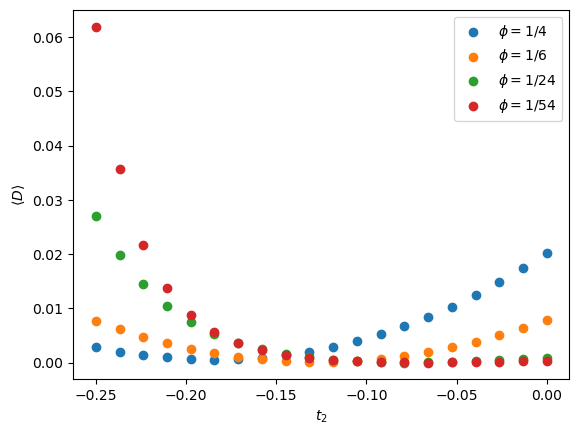

--- 183.54412293434143 seconds ---


In [17]:
#Fig 3 DISM

start_time = time.time()
from joblib import Parallel, delayed
print('running')
grain = 100
qs = np.array([4, 6, 24, 54])
def my_task(q, t_temp):
    n_phi = 1/q
    points = np.array([None, None])
    t_3 = t_temp
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dism = np.array([t_3, DISM_int(t_3, q, 0)])
    return dism
for q in qs:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    results = np.array(Parallel(n_jobs=8)(delayed(my_task)(q, t_temp) for t_temp in np.linspace(-0.25, 0, 20)))
    plt.scatter(results[:, 0], results[:, 1], label = r'$\phi = 1/{}$'.format(q))
plt.legend()
plt.xlabel(r'$t_2$')
plt.ylabel(r'$\langle D \rangle$')
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))



#https://joblib.readthedocs.io/en/stable/

running


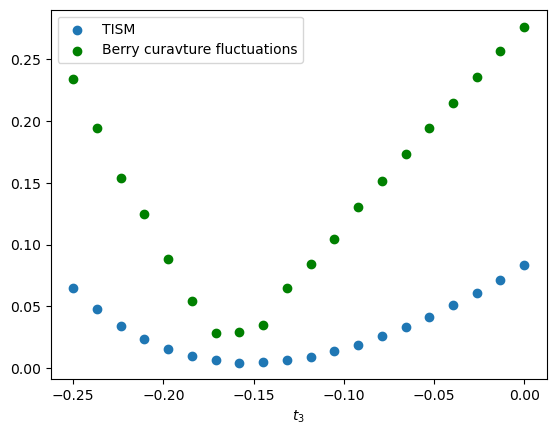

--- 12.609463930130005 seconds ---


In [23]:
start_time = time.time()
from joblib import Parallel, delayed
print('running')
grain = 100
qs = np.array([4])#, 6, 24, 54])
def my_task(q, t_temp):
    n_phi = 1/q
    points = np.array([None, None])
    t_3 = t_temp
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    tism = np.array([t_3, TISM_int(t_3, q, 0)])
    return tism

def my_task2(q, t_temp):
    n_phi = 1/q
    points = np.array([None, None])
    t_3 = t_temp
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    bc = np.array([t_3, bc_std(t_3, q, 0)])
    return bc



for q in qs:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    results = np.array(Parallel(n_jobs=8)(delayed(my_task)(q, t_temp) for t_temp in np.linspace(-0.25, 0, 20)))
    plt.scatter(results[:, 0], results[:, 1], label = 'TISM')
for q in qs:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    results2 = np.array(Parallel(n_jobs=8)(delayed(my_task2)(q, t_temp) for t_temp in np.linspace(-0.25, 0, 20)))
    plt.scatter(results2[:,0], results2[:, 1], label = 'Berry curavture fluctuations', color = 'green')
plt.legend()
plt.xlabel(r'$t_3$')
#plt.ylabel(r'$std(bc)$')
plt.savefig('std_bc_plot.png', dpi = 1000)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))



#https://joblib.readthedocs.io/en/stable/

# QGT fluctuations

running


/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel

/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel_2512/1989066114.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/yt/nsbv148d3fs6lsxdydmhyvmc0000gp/T/ipykernel

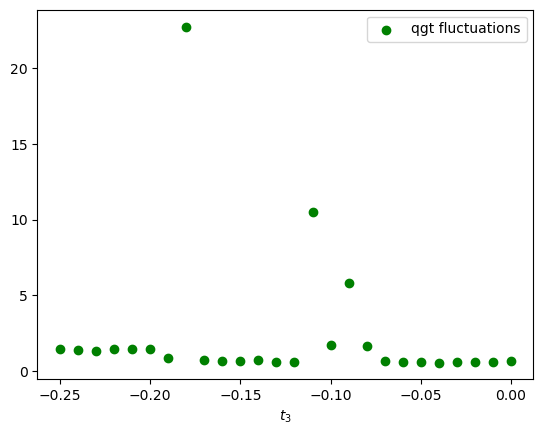

--- 83.3188648223877 seconds ---


In [16]:
start_time = time.time()
from joblib import Parallel, delayed
print('running')
grain = 200
qs = np.array([15])#, 6, 24, 54])

def my_task2(q, t_temp):
    n_phi = 1/q
    points = np.array([None, None])
    t_3 = t_temp
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    bc = np.array([t_3, g_std(t_3, q, 0)])
    return bc



for q in qs:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    results2 = np.array(Parallel(n_jobs=8)(delayed(my_task2)(q, t_temp) for t_temp in np.linspace(-0.25, 0, 26)))
    plt.scatter(results2[:,0], results2[:, 1], label = 'qgt fluctuations', color = 'green')
plt.legend()
plt.xlabel(r'$t_3$')
#plt.ylabel(r'$std(bc)$')
plt.savefig('qgt_fluct_{}_15_100000small.png'.format(grain), dpi = 1000)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))



#https://joblib.readthedocs.io/en/stable/

# INCLUDE GAP TO WIDTH ((BAND GAP)/(BAND WIDTH))

In [12]:
def band_gap(q, i):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    eigenvalues_arr = H_eigenvalues(q)
    eigenvectors_arr = H_eigenvectors(q)
    if i+1 == q:
        return np.min(eigenvalues_arr[i]) - np.max(eigenvalues_arr[i-1])
    return np.min(eigenvalues_arr[i+1]) - np.max(eigenvalues_arr[i])
def band_width(q, i):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    eigenvalues_arr = H_eigenvalues(q)[i]
    eigenvectors_arr = H_eigenvectors(q)[i]
    return np.max(eigenvalues_arr) - np.min(eigenvalues_arr)
def flatness_param(q, i):
    return band_gap(q, i)/band_width(q, i)

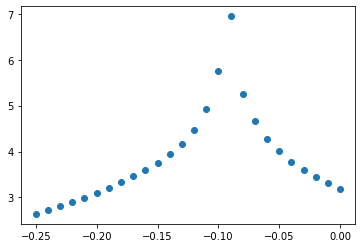

In [15]:
q, i = 5, 0
t_range = np.linspace(-0.25, 0, 26)
gap_width_points = np.empty(26)
for j, discard in enumerate(gap_width_points):
    t_3 = t_range[j]
    gap_width_points[j] = np.log(band_gap(q, i)) - np.log(band_width(q, i))
plt.scatter(t_range, gap_width_points)

In [10]:
q =4
k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
berry_curv_std(q, 0)

NameError: name 'berry_curv' is not defined

In [11]:
print(band_gap(5, 0), band_width(5, 0))

0.979153215020665 0.06977538484912138
